In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate

attenuation across homogenous region is the attenuation coefficient µ times the thickness of that region for a beam (µ*x=ln(I<sub>0</sub>/I)). I~e^-x, so I<sub>0</sub>/I~e^x, which means that taking ln linearizes it, making the attenuation proportional to distance across a homogenous region

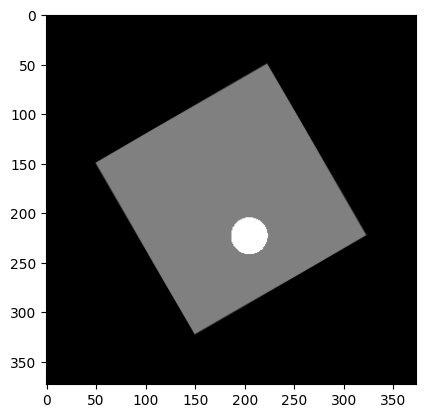

In [20]:
square = rotate(np.ones([200, 200]), 30, resize=True)
image = np.pad(square, pad_width=50)
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv-0.1)**2+(yv-0.2)**2<0.01] = 2
# square = np.ones([50, 50])*2
# # Insert another square at non-central position
# x1, y1 = image.shape[1] // 2, image.shape[0] // 2
# x2, y2 = x1 + square.shape[1], y1 + square.shape[0]
# print(x1, x2, y1, y2)
# image[y1:y2, x1:x2] = square

# plt.imshow(image, cmap='gray')

In [3]:
dtheta = 1
thetas = np.arange(0, 180, dtheta)
rs = thetas / 180 * np.pi
d = np.linspace(-1, 1, image.shape[0])
rotations = np.array([rotate(image, theta) for theta in thetas])

(180, 373, 373)

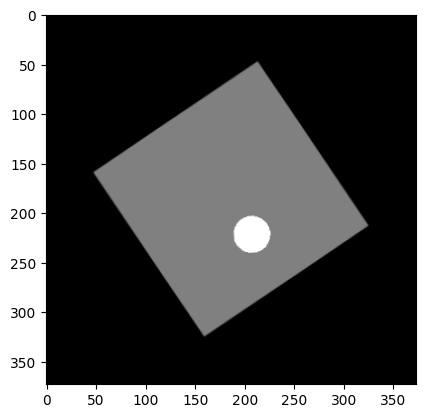

In [4]:
def plot_img(image):
    # xv, yv = np.meshgrid(_, _)
    plt.imshow(image, cmap='gray')

plot_img(rotations[4])
rotations.shape

In [5]:
dr = np.diff(d)[0]
p = rotations.sum(axis=2) * dr
# p = np.array([rotation.sum(axis=0)*dr for rotation in rotations])
p.shape

(180, 373)

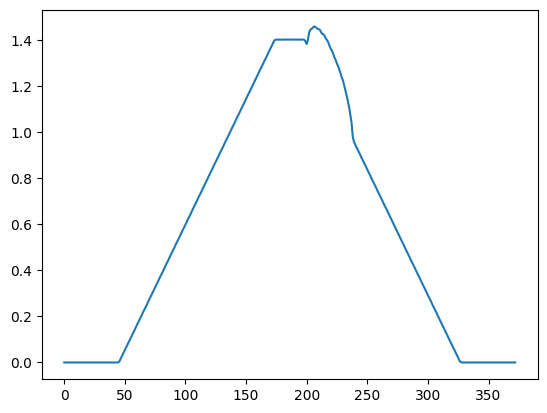

In [6]:
plt.plot(p[10])

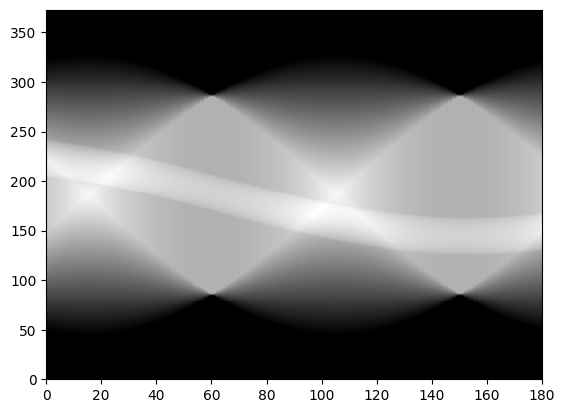

In [7]:
plt.pcolor(p.T, shading='auto', cmap='gray')

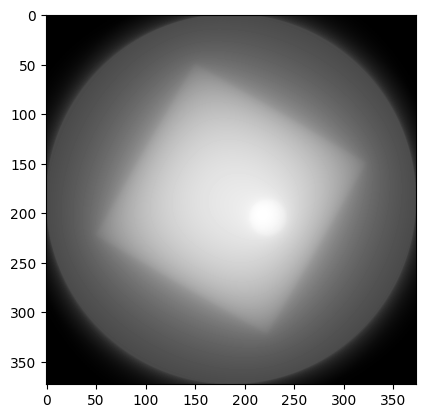

In [8]:
def back_project(p):
    laminogram = np.zeros((p.shape[1], p.shape[1]))
    for i in range(p.shape[0]):
        temp = np.tile(p[i],(p.shape[1],1))
        temp = rotate(temp, dtheta*i)
        laminogram += temp
    return laminogram
recon = back_project(p)
plot_img(recon)

In [9]:
# # Backprojection
# interpolate_p = RectBivariateSpline(d, thetas, p.T)
# def BP(x, y): return interpolate_p(x * np.cos(thetas) + y * np.sin(thetas), thetas, grid=False).sum() * dtheta
# xv, yv = np.meshgrid(d, d)
# bp = np.vectorize(BP)(xv, yv)
# plt.imshow(bp, cmap='gray')


In [10]:
import scipy.fftpack as fft

In [11]:
def fft_translate(projs):
    #Build 1-d FFTs of an array of projections, each projection 1 row of the array.
    return fft.rfft(projs, axis=1)

def ramp_filter(ffts):
    #Ramp filter a 2-d array of 1-d FFTs (1-d FFTs along the rows).
    ramp = np.floor(np.arange(0.5, ffts.shape[1]//2 + 0.1, 0.5))
    return ffts * ramp

def inverse_fft_translate(operator):
    return fft.irfft(operator, axis=1)

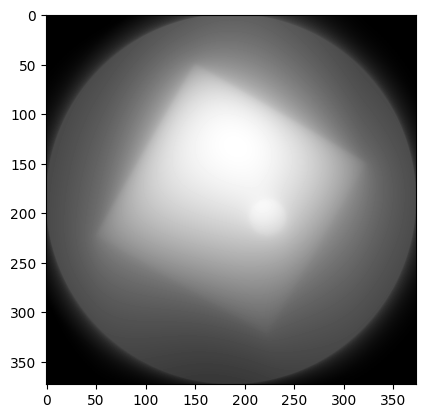

In [12]:
# P = fft(p.T, axis=1)
# nu = np.fft.fftfreq(P.shape[0], d=np.diff(d)[0])

# filtered = (P.T*np.abs(nu))
# p_1 = np.real(ifft(filtered, axis=0))
# plot_img(p_1.T)
fft_p = fft.rfft(p, axis=0)
ramp = np.floor(np.arange(0, fft_p.shape[1]//2 + 0.1, 0.5))
filtered_sinogram = fft.irfft(fft_p * ramp, axis=0)
filtered_img = back_project(filtered_sinogram)
plot_img(filtered_img)

In [13]:
# interpolate_p_1 = RectBivariateSpline(d, thetas, p.T)
# def FBP(x, y): return interpolate_p_1(x * np.cos(thetas) + y * np.sin(thetas), thetas, grid=False).sum() * dtheta
# fbp = np.vectorize(FBP)(xv, yv)
# plt.imshow(fbp, cmap='gray')

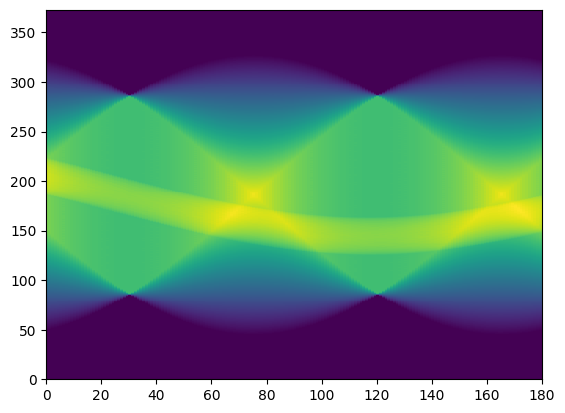

In [14]:
from skimage.transform import radon, iradon
sinogram = radon(image, theta=np.arange(0, 180, 1))
plt.pcolor(sinogram)

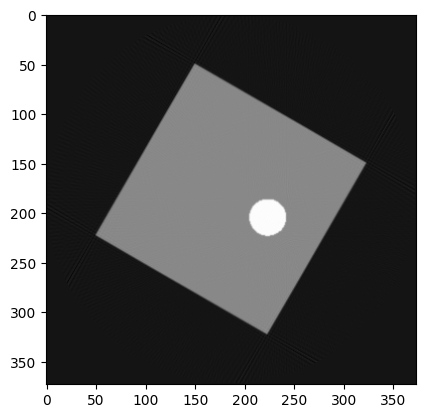

In [15]:
plot_img(iradon(p.T))